In [153]:
import plotly.express as px
import pandas as pd
from tqdm import tqdm
import geopy.distance
import math
import seaborn as sns
import smoothfit
import matplotlib.pyplot as plt
%matplotlib notebook

In [203]:
fn = "/Users/anish/temp/output3.pos"

with open(fn) as f:
    lines = [x.strip() for x in f.readlines()]
    lines = [x for x in lines if not x.startswith("%")]
    lines = [[x.strip() for x in line.split(",")] for line in lines]

In [204]:
lines = lines[1000:]

In [205]:
out = []

MAX_STDDEV = 0.4
MIN_SATELLITES = 2
ALLOWED_FIXTYPES = {1: 2, 2: 1, 4: 0} # convert between RTKLIB format and our format

last_pos = None
last_vel = None


for timestr, lat, lng, alt, fixtype, ns, sdn, sde, sdu, _, _, _, _, _ in lines:
    h, m, s = timestr.split(" ")[-1].split(":")
    ts = int(h)*60*60 + int(m)*60 + float(s)
    ts = round(ts, 3)

    lat = float(lat)
    lng = float(lng)
    alt = float(alt)
    fixtype = int(fixtype)
    ns = int(ns)
    sdn = float(sdn)
    sde = float(sde)
    sdu = float(sdu)
    
    if fixtype not in ALLOWED_FIXTYPES:
        continue
        
    horiz_acc = round(math.sqrt(sdn**2 + sde**2), 4) # TODO this is not statistically accurate
    vert_acc = round(sdu, 4) # TODO this may or may not need some math done on it
    
    if horiz_acc > MAX_STDDEV:
        continue
        
    if ns < MIN_SATELLITES:
        continue
        
    # TODO fit some kind of curve to compute a smooth measurement of speed
    if last_pos:
        diff = geopy.distance.geodesic((last_pos[0], last_pos[1]), (lat, lng)).meters
        
        timediff = (ts - last_pos[2])
        ground_speed_raw = round((diff/timediff)*2.23694, 4) # convert to mph
        
        if last_vel:
            acceleration = (ground_speed_raw - last_vel[0]) / (ts - last_vel[1])   
        else:
            acceleration = 0
        
        last_vel = (ground_speed_raw, ts)
        
        if acceleration > 30 or ground_speed_raw > 20:
            continue
        
        speed_acc = 0 # TODO
    else:
        last_pos = (lat, lng, ts)
        continue
        
    last_pos = (lat, lng, ts)
    
    msg = {
        "timestamp": ts,
        "rtktype": ALLOWED_FIXTYPES[fixtype],
        "latitude": lat,
        "longitude": lng,
        "ground_speed_raw": ground_speed_raw, # mph
        "ground_speed": ground_speed_raw, # mph, TODO: should be smoothed
        "altitude": alt, # meters
        "horizontal_accuracy": horiz_acc,
        "vertical_accuracy": vert_acc,
        "speed_accuracy": speed_acc
    }
    
    out.append(msg)

<IPython.core.display.Javascript object>


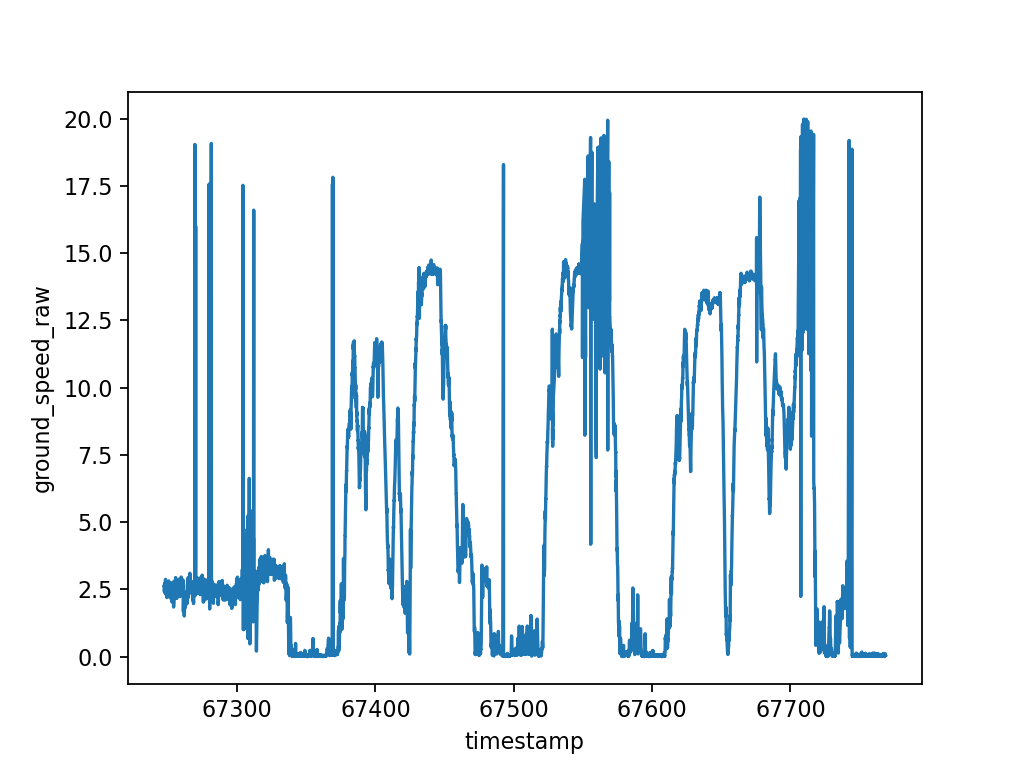

<AxesSubplot:xlabel='timestamp', ylabel='ground_speed_raw'>

In [206]:
df = pd.DataFrame.from_dict(out)
sns.lineplot(data=df, x="timestamp", y="ground_speed_raw")

In [207]:
df["ground_speed_raw"].max()

19.9812

In [208]:
df.to_csv(fn.replace(".pos", ".csv"))

In [209]:
ll = list(df["timestamp"])
oo = []
for i in range(len(ll)-1):
    oo.append(round(ll[i+1]-ll[i], 2))
    
print({x: oo.count(x) for x in set(oo)})

#plt.hist(oo, bins=30)

{0.35: 1, 0.4: 3, 0.2: 14, 0.45: 3, 0.25: 9, 1.1: 1, 0.75: 3, 1.3: 1, 0.65: 1, 1.0: 1, 0.5: 1, 0.6: 2, 0.05: 9320, 0.7: 1, 0.1: 235, 0.15: 44, 0.3: 3, 0.55: 6, 0.8: 1, 1.55: 1, 1.05: 1, 1.15: 1}


In [210]:
layers = [
    {
        "below": "traces",
        "sourcetype": "raster",
        "source": [
            "https://imagery.pasda.psu.edu/arcgis/rest/services/pasda/PEMAImagery2018_2020/MapServer/WMTS/tile/1.0.0/pasda_PEMAImagery2018_2020/default/default028mm/{z}/{y}/{x}.png"
        ]
    }
]

fig = px.scatter_mapbox(df,
                        lat="latitude", lon="longitude",
                        color="ground_speed",
                        hover_data=["horizontal_accuracy",
                                    "speed_accuracy",
                                    "altitude",
                                    "timestamp"],
                        zoom=15, size_max=18,
                        height=400, width=800)

fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=layers
)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [211]:
fig.write_html(fn.replace(".pos", ".html"))

<IPython.core.display.Javascript object>


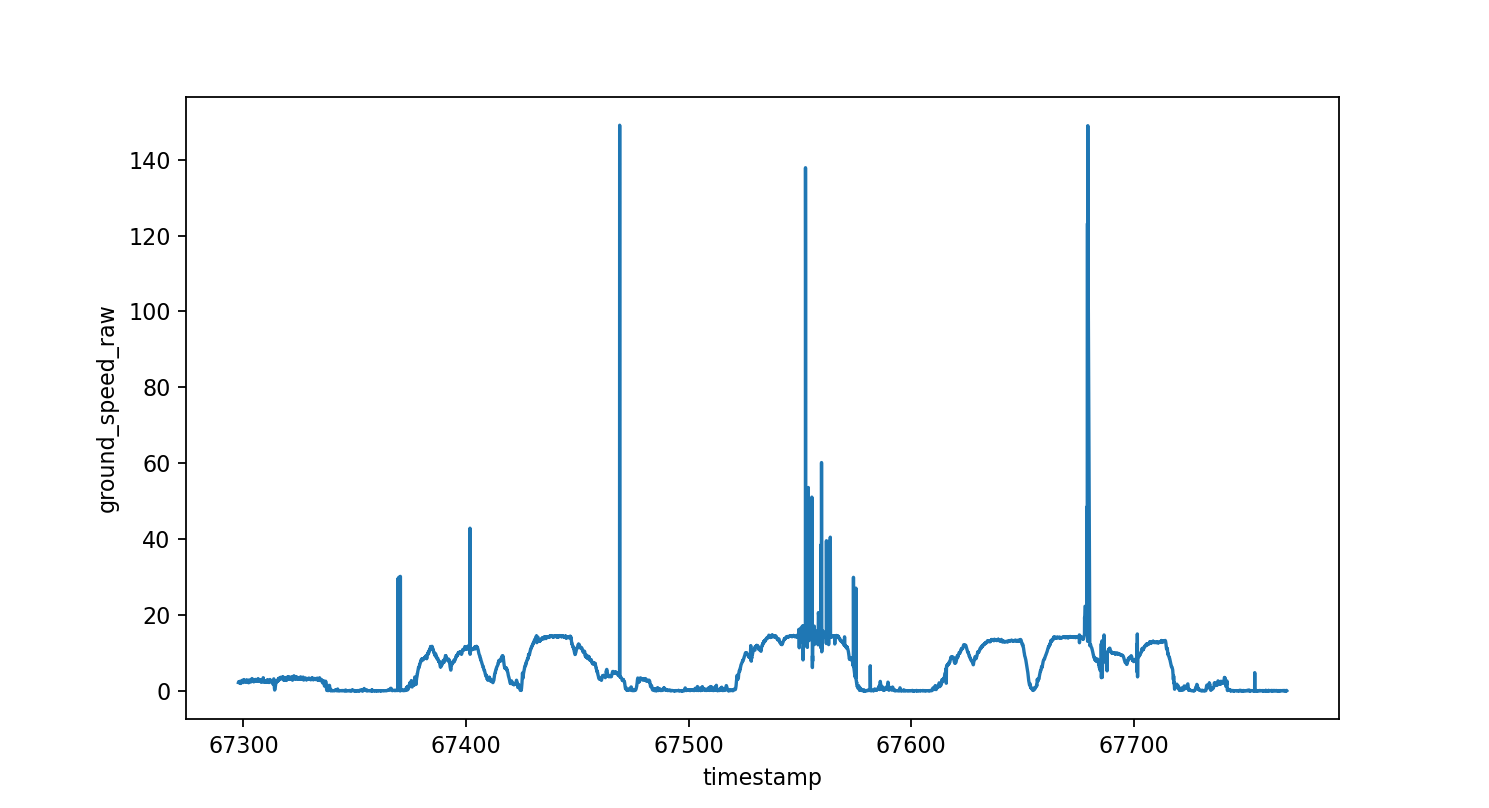

<AxesSubplot:xlabel='timestamp', ylabel='ground_speed_raw'>

<AxesSubplot:xlabel='timestamp', ylabel='rtktype'>

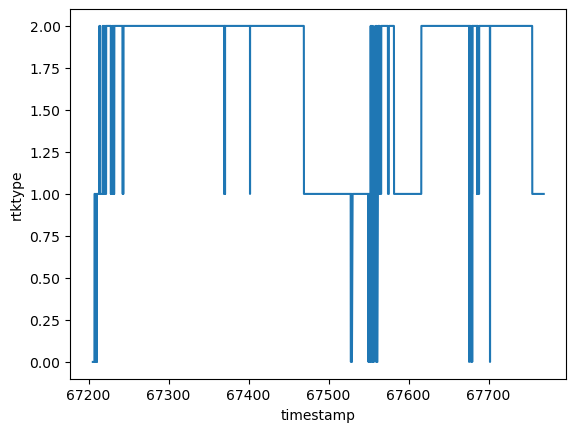